# Andrea Cavallaro

## Abilità Informatiche e Telematiche 2022/2023

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
TEST_COVARIANCE=True
PLOTS=True

# 1. Singolo multipolo

## 1.1. Apertura file con la prima misura del primo set

In [3]:
fname='data/MockMeasures_2PCF_Test1/MockMeasures_2PCF_Correlation_MULTIPOLES_Test1_1.fits'
file = fits.open(fname)

## 1.2. Lettura di un multipolo da un set di dati

In [4]:
Nbins = 200        #lunghezza vettore dati
Nmeasures = 10000  #prime 1000 misure
test = 3           #per selezionare il test (1,2 o 3)
measures = []

In [5]:
for i in np.arange(Nmeasures)+1:
    
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    #print(f'apro il file N. {i} chiamato {fname}')
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures.append(table['XI0'])   #XI0 -> primo multipolo
    
    if i==1:
       scale = table['SCALE']       #SCALE -> prima colonna con bin
    del table
    file.close()
    
measures = np.asarray(measures)


In [6]:
# chek dimensioni matrice: 200 misure, 10000 volte. (10000,200)
print(measures.shape)

(10000, 200)


In [7]:
measures = measures.transpose()

## 1.3. Calcolo numerico della matrice di covarianza con numpy

In [8]:
cov_xi = np.cov(measures, bias=False)
mean_xi = np.mean(measures,axis=1)
#print(mean_xi)
#print(covMatrix.shape)      # check shape (200,200)

### check matrice covarianza

In [9]:
if TEST_COVARIANCE:
    print('Running test to see if I understand the covariance:')

    AVE = np.zeros((Nbins,),dtype=float)
    COV = np.zeros((Nbins,Nbins),dtype=float)

    for i in range(Nmeasures):
        AVE += measures[:,i]
    AVE /= Nmeasures

    for i in range(Nbins):
        for j in range(Nbins):
            COV[i,j] = (np.sum(measures[i]*measures[j]) - AVE[i]*AVE[j]*Nmeasures) / (Nmeasures-1)

    print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.abs(COV-cov_xi))))

Running test to see if I understand the covariance:
Largest deviation between my calculation and numpy: 5.663667776954762e-13


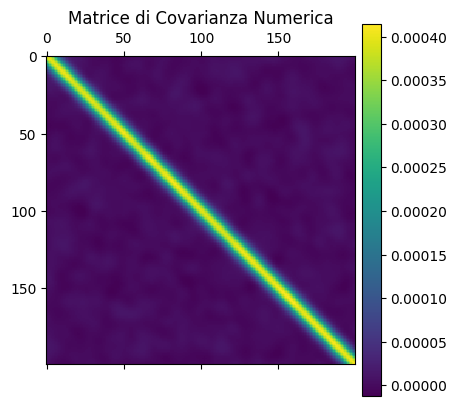

In [10]:
plt.matshow(cov_xi)

plt.title('Matrice di Covarianza Numerica') 

plt.colorbar(orientation="vertical", pad=0.02)
#plt.savefig('cov_num_1.png')

plt.show()

## 1.4. Calcolo della matrice di covarianza teorica

In [11]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

In [12]:
## Definizioni per costruire la matrice di covarianza teorica
def covf(x1, x2, sig, l):
    return sig**2.*np.exp(-(x1-x2)**2./(2.*l**2.))
def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)
    

### covarianza del primo multipolo

In [13]:
cov_th = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

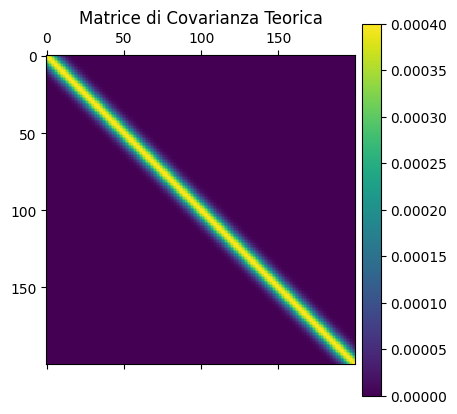

In [14]:
plt.matshow(cov_th)

plt.title('Matrice di Covarianza Teorica') 
plt.colorbar(orientation="vertical", pad=0.02)
#plt.savefig('cov_th_1.png')

plt.show()

### matrice dei residui non normalizzata

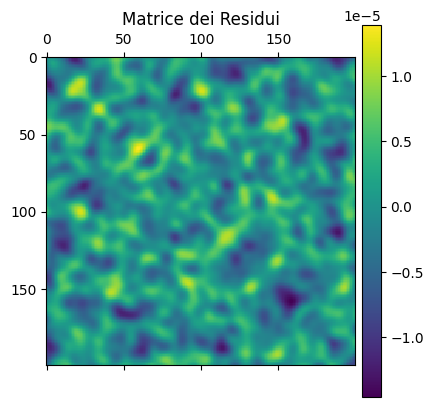

In [15]:
plt.matshow(cov_th-cov_xi)

plt.title('Matrice dei Residui') 
plt.colorbar(orientation="vertical", pad=0.02)

plt.show()

### matrice di correlazione

In [16]:
corr = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        corr[i,j]=cov_th[i,j]/(cov_th[i,i]*cov_th[j,j])**0.5

### matrice residui normalizzati

In [17]:
res_norm=np.zeros((Nbins,Nbins),dtype=float) 
for i in range(Nbins):
    for j in range(Nbins):
        res_norm[i][j]=(cov_th[i][j]-cov_xi[i][j])*((Nmeasures-1)/((1.+corr[i][j])*cov_th[i][i]*cov_th[j][j]))**0.5 

In [18]:
deviation=np.std(res_norm.reshape(Nbins**2))

print(f"deviazione dei residui normalizzati: {deviation}")

deviazione dei residui normalizzati: 0.988376470364332


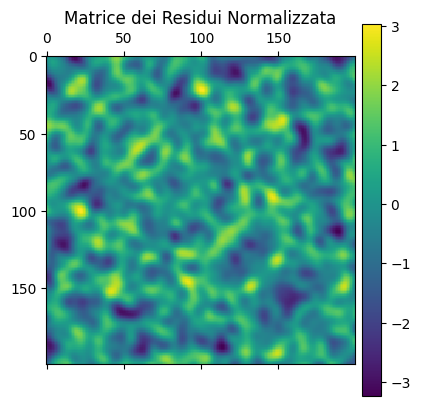

In [19]:
plt.matshow(res_norm)

plt.title('Matrice dei Residui Normalizzata')
plt.colorbar(orientation="vertical", pad=0.02)
#plt.savefig('res_1.png')

plt.show()

# 2. Tre multipoli

## 2.1 Lettura dei tre multipoli

In [20]:
measures_1=[]
measures_2=[]
measures_3=[]

for i in np.arange(Nmeasures)+1:
    fname= f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file=fits.open(fname)
    table=file[1].data.copy()
    measures_1.append(table['XI0'])
    measures_2.append(table['XI2'])      #multipoli memorizzati in 3 array
    measures_3.append(table['XI4'])
    if i==1:
        scale=table['SCALE']    
    del table
    file.close()
    
measures_1=np.asarray(measures_1)
measures_2=np.asarray(measures_2) 
measures_3=np.asarray(measures_3)

In [21]:
# multipoli concatenati in un'unica matrice
measures=np.concatenate((measures_1.transpose(),measures_2.transpose(),measures_3.transpose()))  

In [22]:
print(measures.shape) #check shape 200x3 misure 1000 volte (600,1000)

(600, 10000)


## 2.2. Calcolo della covarianza numerica

In [23]:
cov_xi1=np.cov(measures, bias=True)

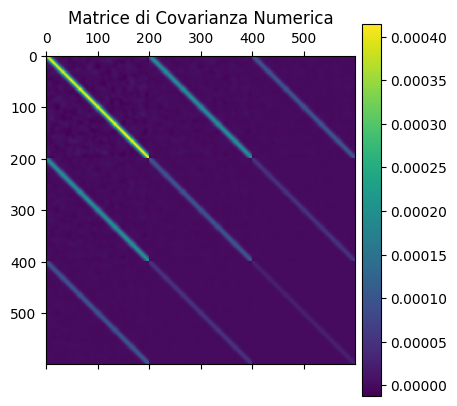

In [24]:
plt.matshow(cov_xi1)


plt.title('Matrice di Covarianza Numerica') 
plt.colorbar(orientation="vertical", pad=0.02)

plt.savefig('cov_num_tot.png')
plt.show()

## 2.3. Calcolo della covarianza teorica

In [25]:
cov_th1=np.zeros((600,600),dtype=float)

for l1 in range(0,3):
    for l2 in range(0,3):
        for i in range(Nbins):
            for j in range(Nbins):
                cov_th1[i+l1*Nbins][j+l2*Nbins]=covf1f2(scale[i],scale[j],sigs[l1],ls[l1],sigs[l2],ls[l2])

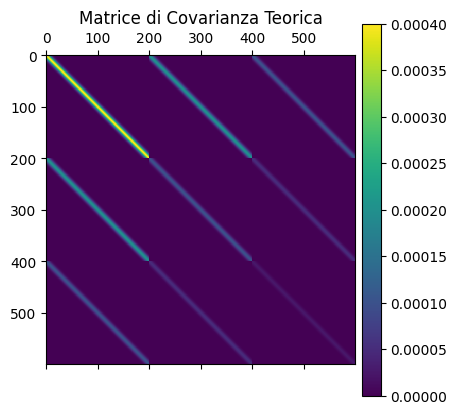

In [26]:
plt.matshow(cov_th1)

plt.title('Matrice di Covarianza Teorica') 
plt.colorbar(orientation="vertical", pad=0.02)

plt.savefig('cov_th_tot.png')
plt.show()

### matrice residui non normalizzata

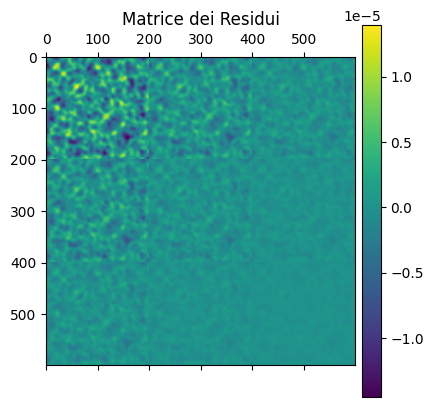

In [27]:
plt.matshow(cov_th1-cov_xi1)


plt.title('Matrice dei Residui') 
plt.colorbar(orientation="vertical", pad=0.02)

plt.show()

### matrice di correlazione

In [28]:
corr1=np.zeros((600,600),dtype=float)

for i in range(600):
    for j in range(600):
        corr1[i][j]=cov_th1[i][j]/(cov_th1[i][i]*cov_th1[j][j])**0.5

### matrice residui normalizzata

In [29]:
res_norm1=np.zeros((600,600),dtype=float)

for i in range(600):
    for j in range(600):
        res_norm1[i][j]=(cov_th1[i][j]-cov_xi1[i][j])*((Nmeasures-1)/((1.+corr1[i][j])*cov_th1[i][i]*cov_th1[j][j]))**0.5 

In [30]:
deviation=np.std(res_norm1.reshape(600**2))

print(f"deviazione dei residui normalizzati: {deviation}")

deviazione dei residui normalizzati: 0.9882692939064301


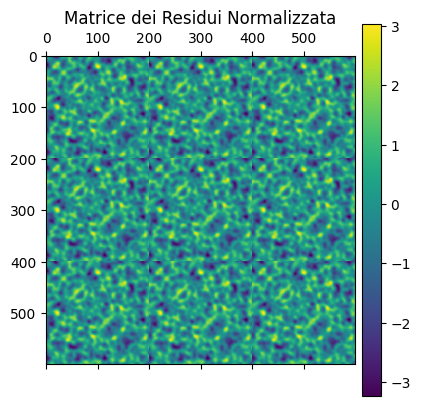

In [31]:
plt.matshow(res_norm1)

plt.title('Matrice dei Residui Normalizzata') 
plt.colorbar( orientation="vertical", pad=0.02)

plt.savefig('res_tot.png')
plt.show()